In [2]:
# Imports
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [9]:
main_dir = '/kaggle/input'
main_data_dir = 'mayo-clinic-strip-ai'

os.listdir(os.path.join(main_dir, main_data_dir))

['sample_submission.csv',
 'other',
 'train.csv',
 'test.csv',
 'test',
 'other.csv',
 'train']

In [11]:
%%time
# Get CSV files
train_df = pd.read_csv(os.path.join(main_dir, main_data_dir, 'train.csv'))
test_df = pd.read_csv(os.path.join(main_dir, main_data_dir, 'test.csv'))
other_df = pd.read_csv(os.path.join(main_dir, main_data_dir, 'other.csv'))

print(f"The # of training samples : {len(train_df)}")
print(f"The # of supplementary samples : {len(other_df)}")
print(f"The # of test samples : {len(test_df)}")

The # of training samples : 754
The # of supplementary samples : 396
The # of test samples : 4
CPU times: user 10.6 ms, sys: 64 µs, total: 10.7 ms
Wall time: 12.2 ms


In [12]:
train_df.head()

,image_id,center_id,patient_id,image_num,label
0,006388_0,11,006388,0,CE
1,008e5c_0,11,008e5c,0,CE
2,00c058_0,11,00c058,0,LAA
3,01adc5_0,11,01adc5,0,LAA
4,026c97_0,4,026c97,0,CE


(array([547.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 207.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

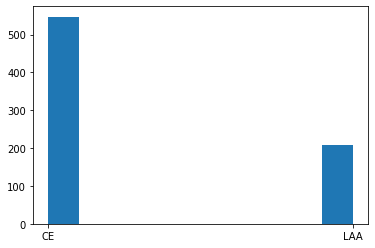

In [22]:
plt.hist(train_df['label'])

In [17]:
# Check if all images exist in train folder
for i in range(len(train_df)):
    image_id = f"{train_df.iloc[i,0]}.tif"   
    image_id = os.path.join(main_dir, main_data_dir, 'train', image_id)
    assert os.path.isfile(image_id), f"{image_id} does not exists"
else:
    print("All Images found")

All Images found


# Pytorch

In [24]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision

## Utility Functions

In [ ]:
def Mayo_Dataset(Dataset):
    